# **Project Objective: PJM Hourly Energy Consumption Forecasting**

The objective of this project is to analyze and forecast hourly energy consumption data for the PJM Interconnection, a regional transmission organization in the United States.

In [2]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#load the dataset
df=pd.read_csv('/content/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
#convert to datetime and set datetime as index
df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index(['Datetime'],inplace=True)

In [5]:
#create time-based features
df['hour']=df.index.hour
df['day']=df.index.day
df['month']=df.index.month
df['year']=df.index.year
df['weekday']=df.index.weekday #0 indicates monday
df['is_weekday']=df['weekday']>=5

#check for structure
print(df.head())

                     PJMW_MW  hour  day  month  year  weekday  is_weekday
Datetime                                                                 
2002-12-31 01:00:00   5077.0     1   31     12  2002        1       False
2002-12-31 02:00:00   4939.0     2   31     12  2002        1       False
2002-12-31 03:00:00   4885.0     3   31     12  2002        1       False
2002-12-31 04:00:00   4857.0     4   31     12  2002        1       False
2002-12-31 05:00:00   4930.0     5   31     12  2002        1       False


In [22]:
#check for null values
df.isnull().sum()

,0
PJMW_MW,0
hour,0
day,0
month,0
year,0
weekday,0
is_weekday,0


# **Data Visualisation**

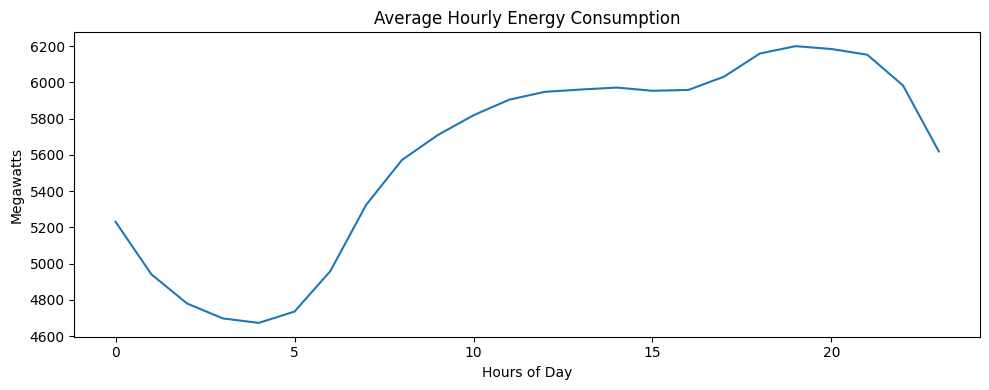

In [6]:
 #Average Hourly Consumption
plt.figure(figsize=(16,6))
sns.lineplot(x='hour',y='PJMW_MW',data=df.groupby('hour')['PJMW_MW'].mean().reset_index())
plt.title("Average Hourly Energy Consumption")
plt.xlabel("Hours of Day")
plt.ylabel('Megawatts')
plt.tight_layout()
plt.show()

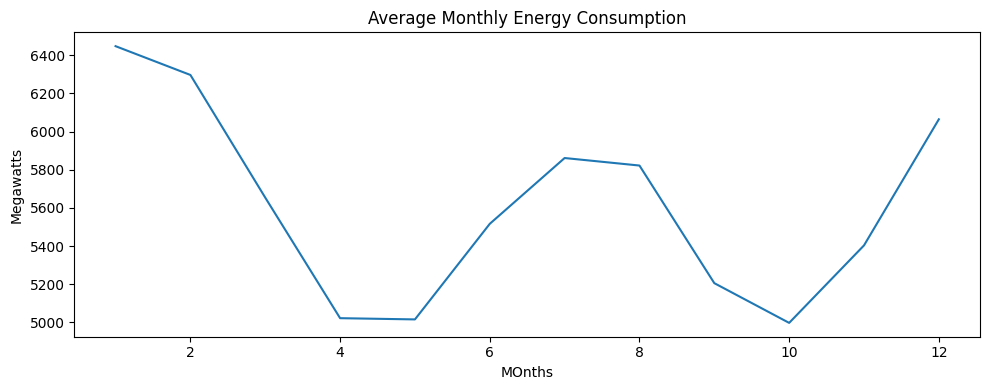

In [7]:
#Average Monthly Consumption
plt.figure(figsize=(16,6))
sns.lineplot(x='month',y='PJMW_MW',data=df.groupby('month')['PJMW_MW'].mean().reset_index())
plt.title("Average Monthly Energy Consumption")
plt.xlabel("MOnths")
plt.ylabel('Megawatts')
plt.tight_layout()
plt.show()

In [8]:
df.columns

Index(['PJMW_MW', 'hour', 'day', 'month', 'year', 'weekday', 'is_weekday'], dtype='object')

/tmp/ipython-input-19-2095508934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday',y='PJMW_MW',data=df.groupby('weekday')['PJMW_MW'].mean().reset_index(),palette='coolwarm')


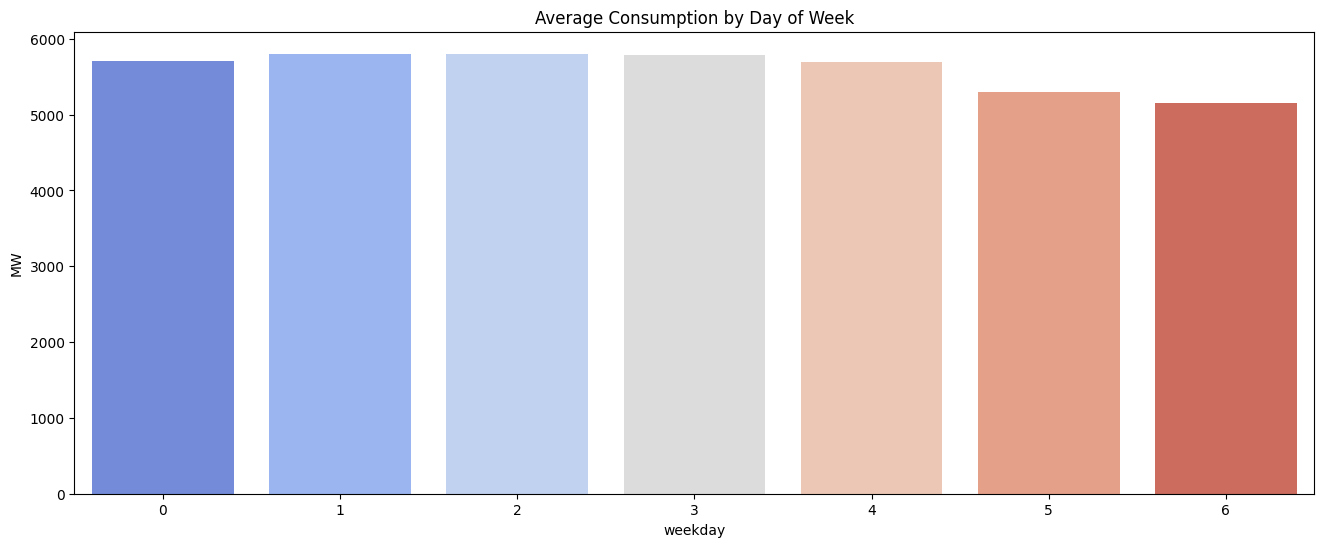

In [19]:
#Average Energy Consumption per days of week
plt.figure(figsize=(16,6))
sns.barplot(x='weekday',y='PJMW_MW',data=df.groupby('weekday')['PJMW_MW'].mean().reset_index(),palette='coolwarm')
plt.title('Average Consumption by Day of Week')
plt.ylabel('MW')
plt.show()

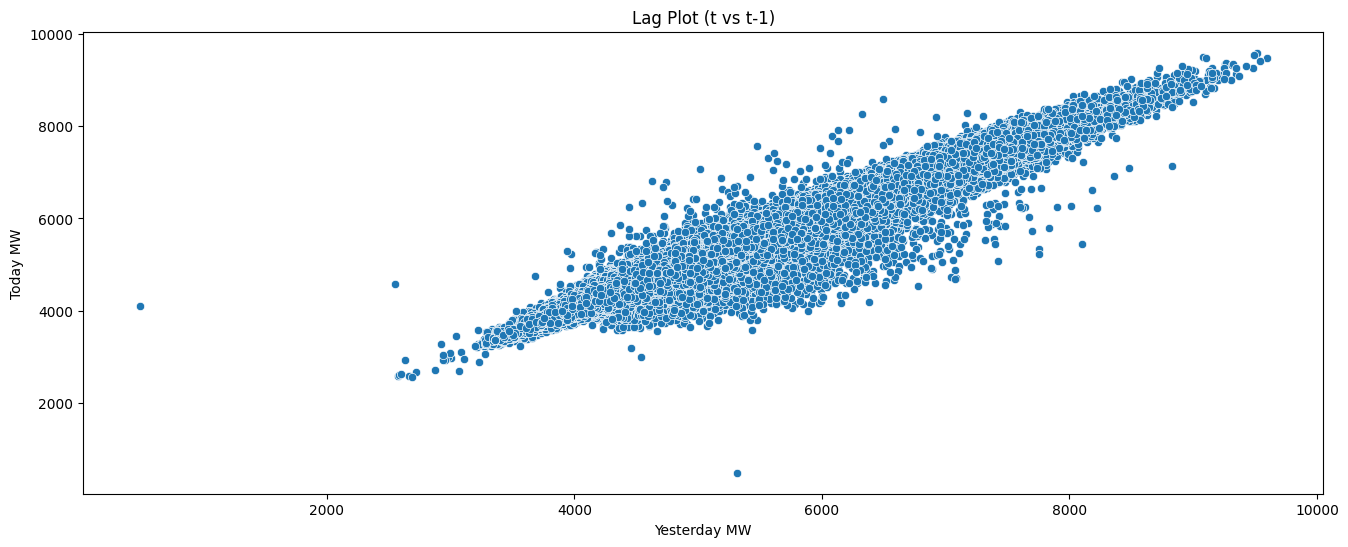

In [18]:
# Remove duplicate indices (keep first occurrence)
df = df[~df.index.duplicated(keep='first')]

plt.figure(figsize=(16, 6))
sns.scatterplot(x=df['PJMW_MW'].shift(1), y=df['PJMW_MW'])
plt.title('Lag Plot (t vs t-1)')
plt.xlabel('Yesterday MW')
plt.ylabel('Today MW')
plt.show()


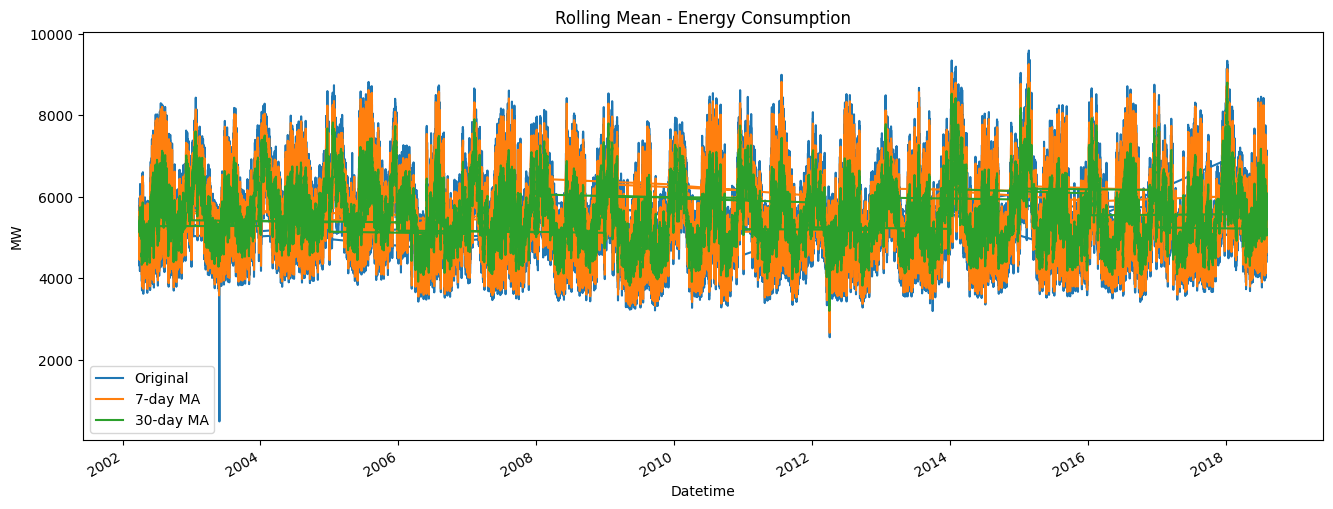

In [17]:
plt.figure(figsize=(16, 6))
df['PJMW_MW'].plot(label='Original')
df['PJMW_MW'].rolling(window=7).mean().plot(label='7-day MA')
df['PJMW_MW'].rolling(window=30).mean().plot(label='30-day MA')
plt.title('Rolling Mean - Energy Consumption')
plt.ylabel('MW')
plt.legend()
plt.show()


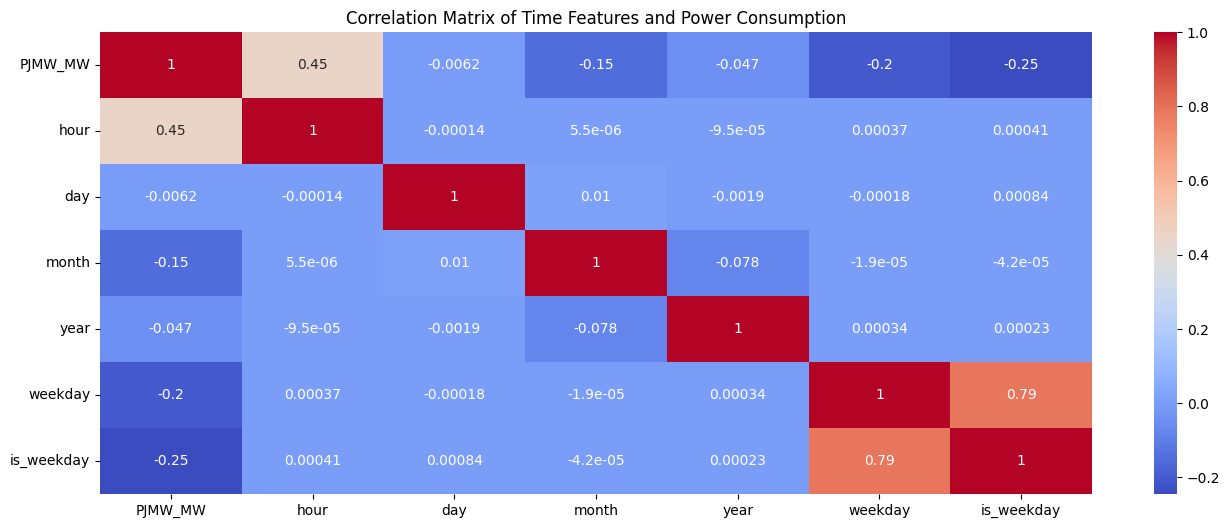

In [21]:
# Correlation Heatmap
# Displays relationships between time-based features and power usage
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.title("Correlation Matrix of Time Features and Power Consumption")
plt.show()

From the above correlation ,

we found that there is no multi-collinearity in the dataset .

# **Model Development and Forecasting**

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np